In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config


In [39]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)
df_tgt_ct = df_tgt_ct.drop('ds',axis=1).resample('M').mean()

In [41]:
y = df_tgt_ct.y[:-20]
y_val = df_tgt_ct[-20:]

In [42]:
# 一次
fit = SimpleExpSmoothing(y,initialization_method='estimated').fit()

In [43]:
fit.summary()

Dep. Variable:,y,No. Observations:,68
Model:,SimpleExpSmoothing,SSE,51001.598
Optimized:,True,AIC,454.167
Trend:,None,BIC,458.606
Seasonal:,None,AICC,454.802
Seasonal Periods:,None,Date:,"Tue, 17 May 2022"
Box-Cox:,False,Time:,10:03:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,165.29995,l.0,True


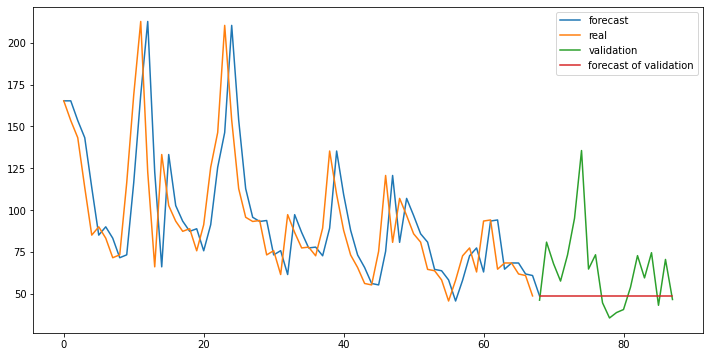

In [97]:
idx = list(range(len(df_tgt_ct)))
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()

In [82]:
fit2 = ExponentialSmoothing(y, trend='add').fit(optimized=True)

In [84]:
fit2.summary()

Dep. Variable:,y,No. Observations:,68
Model:,ExponentialSmoothing,SSE,50800.342
Optimized:,True,AIC,457.898
Trend:,Additive,BIC,466.776
Seasonal:,None,AICC,459.275
Seasonal Periods:,None,Date:,"Tue, 17 May 2022"
Box-Cox:,False,Time:,10:14:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


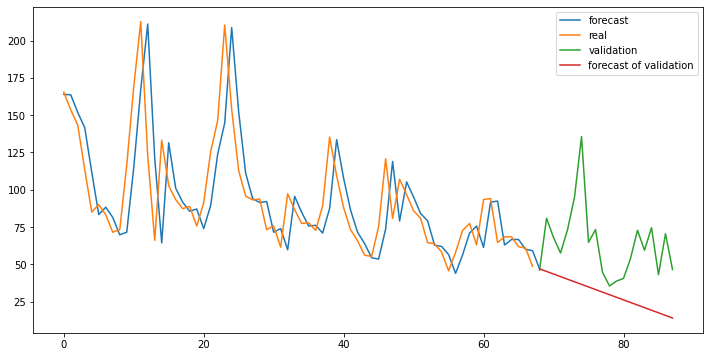

In [96]:
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit2.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit2.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()

In [89]:
fit3 = Holt(y, exponential=True, damped_trend=True).fit(optimized=True)

In [90]:
fit3.summary()

Dep. Variable:,y,No. Observations:,68
Model:,Holt,SSE,48782.712
Optimized:,True,AIC,457.142
Trend:,Multiplicative,BIC,468.240
Seasonal:,None,AICC,459.009
Seasonal Periods:,None,Date:,"Tue, 17 May 2022"
Box-Cox:,False,Time:,10:17:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9999979,alpha,True
smoothing_trend,0.0001754,beta,True


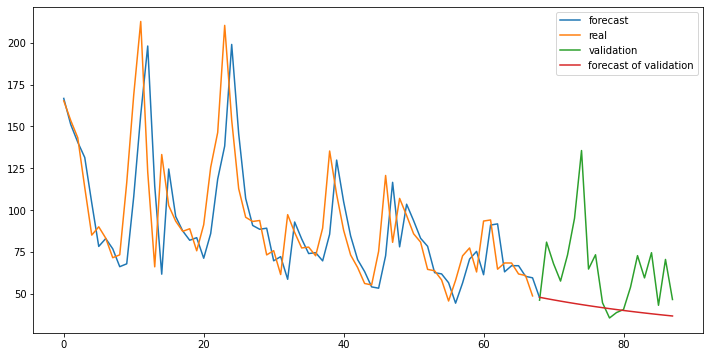

In [95]:
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit3.fittedfcast,index = idx[:len(fit3.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit3.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()